In [118]:
import gc
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split , StratifiedKFold
from tqdm import tqdm

from keras import optimizers
from keras.callbacks import *
from keras.callbacks import EarlyStopping , ModelCheckpoint , ReduceLROnPlateau
from keras.layers import *
from keras.models import Model , load_model , save_model
from keras.preprocessing.image import array_to_img , img_to_array , load_img
from keras.applications.resnet50 import ResNet50 , preprocess_input

%matplotlib inline

# 問題1】コードレビュー

gc https://docs.python.org/ja/3/library/gc.html#module-gc

glob https://docs.python.org/ja/3/library/glob.html?highlight=glob#module-glob

os https://docs.python.org/ja/3/library/os.html?highlight=os#module-os

cv2 https://opencv.org/

tqdm https://github.com/tqdm/tqdm

# keras.callbacks

監視する値の変化が停止した時に訓練を終了します．

 - EarlyStopping
 
 keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
 
 
 - monitor: 監視する値．
 - min_delta: 監視する値について改善として判定される最小変化値．つまり，min_deltaよりも絶対値の変化が小さければ改善していないとみなします．
 - patience: ここで指定したエポック数の間（監視する値に）改善がないと，訓練が停止します．
 - verbose: 冗長モード．
 - mode: {auto, min, max}の内，一つが選択されます．minモードでは，監視する値の減少が停止した際に，訓練を終了します．また，maxモードでは，監視する値の増加が停止した際に，訓練を終了します．autoモードでは，この傾向は自動的に監視されている値から推定します．

# ModelCheckpoint

各エポック終了後にモデルを保存します．

from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Dense(10, input_dim=784, kernel_initializer='uniform'))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

'''
バリデーションロスが減少した場合に，各エポック終了後，モデルの重みを保存します
'''
checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)
model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=0, validation_data=(X_test, Y_test), callbacks=[checkpointer])

 - filepath: 文字列，モデルファイルを保存するパス．
 - monitor: 監視する値．
 - verbose: 冗長モード, 0 または 1．
 - save_best_only: save_best_only=Trueの場合，監視しているデータによって最新の最良モデルが上書きされません．
 - mode: {auto, min, max}の内の一つが選択されます．save_best_only=Trueならば，現在保存されているファイルを上書きするかは，監視されている値の最大化か最小化によって決定されます．val_accの場合，この引数はmaxとなり，val_lossの場合はminになります．autoモードでは，最大化・最小化のいずれかを監視されている値の名前から自動的に推定します．
 - save_weights_only: Trueなら，モデルの重みが保存されます (model.save_weights(filepath))，そうでないなら，モデルの全体が保存されます (model.save(filepath))．
 - period: チェックポイント間の間隔（エポック数）．

 # ReduceLROnPlateau

評価値の改善が止まった時に学習率を減らします．

モデルは訓練が停滞した時に学習率を2〜10で割ることで恩恵を受けることがあります． このコールバックは評価値を監視し，'patience'で指定されたエポック数の間改善が見られなかった場合，学習率を減らします．

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
model.fit(X_train, Y_train, callbacks=[reduce_lr])

 - monitor: 監視する値．
 - factor: 学習率を減らす割合．new_lr = lr * factor
 - patience: 何エポック改善が見られなかったら学習率の削減を行うか．
 - verbose: 整数．0: 何も表示しない．1: 学習率削減時メッセージを表示．
 - mode: auto，min，maxのいずれか． minの場合，監視する値の減少が停止した際に，学習率を更新します． maxの場合，監視する値の増加が停止した時に，学習率を更新します． autoの場合，監視する値の名前から自動で判断します．
 - epsilon: 改善があったと判断する閾値．有意な変化だけに注目するために用います．
 - cooldown: 学習率を減らした後，通常の学習を再開するまで待機するエポック数．
 - min_lr: 学習率の下限．

In [12]:
plt.rcParams["figure.figsize"] = (12,9)

In [95]:
def compute_coverage(df , masks):
    
    df = df.copy()
    
    def cov_to_class(val):
        #0.1刻みでラベル付け
        for i in range(0 , 11):
            if val*10 <= i:
                return i
            
    #クラスがカバーする面積の出力割合
    df["coverage"] = np.mean(masks , axis=(1,2))
    
    
    #Coverageはbinsに分割する必要があります。そうしないと、階層化された分割が不可能になります。
    #because each coverage will occur only once.
    
    df["coverage_class"] = df.coverage.map(
        cov_to_class)
    
    return df

def create_depth_abs_channels(image_tensor):
    image_tensor = image_tensor.astype(np.float32)
    h , w , c = image_tensor.shape
    for row , const in enumerate(np.linspace(0,1 , h)):
        image_tensor[row , : , 1] = const
    image_tensor[: , : , 2] = (
        image_tensor[: , : , 0]*image_tensor[: , : , 1])
    
    x_dx = np.diff(image_tensor[: , : , 0] , axis=0)
    x_dy = np.diff(image_tensor[: , : , 0] , axis=1)
    #画像にフォトフレームのような境界線を引く copyMakeBorder
    #単一色の境界を追加します．次の引数で色の指定 BORDER_CONTANT
    #http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_core/py_basic_ops/py_basic_ops.html
    x_dx = cv2.copyMakeBorder(x_dx,1,0,0,0,cv2.BORDER_CONSTANT,0)
    x_dy = cv2.copyMakeBorder(x_dy,0,0,1,0,cv2.BORDER_CONSTANT,0)
    image_tensor[: , : , 1] = np.abs(x_dx + x_dy)
    
    return image_tensor

cv2.copyMakeBorder（src、top、bottom、left、right、borderType、value）

パラメータ：
 - src：ソース画像です。
 - top：上方向のピクセル数での境界線の幅です。
 - bottom：下方向のピクセル数での境界線の幅です。
 - left：左方向のピクセル数でのボーダー幅です。
 - right：右方向のピクセル数での境界線の幅です。
borderType：追加する境界線の種類を示します。これは、cv2.BORDER_CONSTANT、cv2.BORDER_REFLECTなどの値によって定義されます。これは、ボーダータイプがcv2.BORDER_CONSTANTの場合にボーダーの色を表すオプションのパラメーター

### Data loading & depth merge:

In [23]:
train = pd.read_csv('train1.csv')
test = pd.read_csv("sample_submission.csv")
depth = pd.read_csv("depths.csv")

train_src = "train"

print("train:\n{}".format(train.head()))
print("\ntest:\n{}".format(test.head()))

train = train.merge(depth , how="left",on="id")
test = train.merge(depth , how="left" , on="id")

print("\n{}".format(train.head()))

train:
           id                                           rle_mask
0  575d24d81d                                                NaN
1  a266a2a9df                                          5051 5151
2  75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3  34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4  4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...

test:
           id rle_mask
0  155410d6fa      1 1
1  78b32781d1      1 1
2  63db2a476a      1 1
3  17bfcdb967      1 1
4  7ea0fd3c88      1 1

           id                                           rle_mask    z
0  575d24d81d                                                NaN  843
1  a266a2a9df                                          5051 5151  794
2  75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...  468
3  34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...  727
4  4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...  797


In [24]:
train.head()

,id,rle_mask,z
0,575d24d81d,NaN,843
1,a266a2a9df,5051 5151,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797


In [25]:
test.head()

,id,rle_mask,z_x,z_y
0,575d24d81d,NaN,843,843
1,a266a2a9df,5051 5151,794,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797,797


In [26]:
depth.head()

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783


日付や名前などの共通のデータ列を持っている複数のpandas.DataFrameをその列の値に従って結合するにはpandas.merge()関数またはpandas.DataFrameのmerge()メソッドを使う

 - キーとする列を指定: 引数on, left_on, right_on
 - 結合方法を指定: 引数how
 - 内部結合（inner_join）: how='inner'
 - 左結合（left_join）: how='left'
 - 右結合（right_join）: how='right'
 - 外部結合（outer_join）: how='outer'
 - データの情報を取得: 引数indicator
 - 列名が重複している場合のサフィックスを指定: 引数suffixes
 - 複数の列をキーとする場合
 - キー列でソート: 引数sort
 - インデックスをキーに指定: 引数left_index, right_index

In [33]:
train.merge(depth , how="left" , on="id").head()

,id,rle_mask,z_x,z_y
0,575d24d81d,NaN,843,843
1,a266a2a9df,5051 5151,794,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797,797


### Load images and masks, examine random sample:
画像とマスクをロードし、ランダムなサンプルを調べます

In [72]:
X_train = np.asarray(
    [cv2.imread("train/images/{}.png".format(x) , 0) for x in train.id.tolist()],
    dtype = np.uint8) / 255.
y_train = np.asarray(
    [cv2.imread("train/masks/{}.png".format(x) , 0) for x in train.id.tolist()] , 
    dtype = np.uint8) / 255.

In [73]:
print(X_train.shape , y_train.shape)

(4000, 101, 101) (4000, 101, 101)


 - array()がオブジェクト自体をコピー（別人格）
 - asarray()が参照オブジェクト（名前が違うが中身同じ）
 - tolistは多次元配列でもすべてリストへ変換
 - dtype https://deepage.net/features/numpy-dtype.html

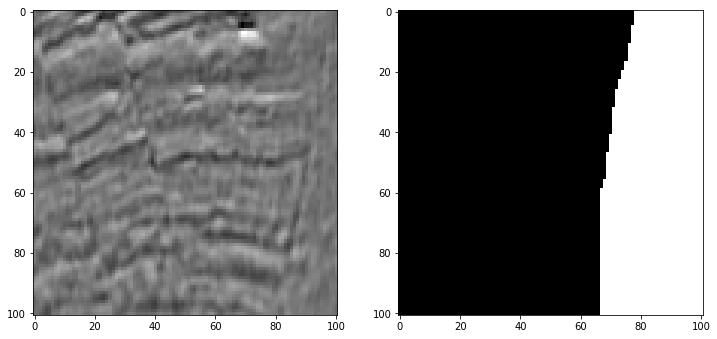

In [66]:
random_index = np.random.randint(0 , X_train.shape[0])

fig , ax = plt.subplots(1 , 2)

ax[0].imshow(X_train[random_index] , cmap="gray")
ax[1].imshow(y_train[random_index] , cmap="gray")
plt.show()

### Compute salt coverage (this will serve as a basis for stratified split):
ソルトカバレッジを計算します（これは階層化された分割の基礎として機能します）

In [79]:
train = compute_coverage(train , y_train)

In [81]:
train.head()

,id,rle_mask,z,coverage,coverage_class
0,575d24d81d,NaN,843,0.000000,0
1,a266a2a9df,5051 5151,794,0.504950,6
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468,0.993334,10
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727,0.149201,2
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797,0.042839,1


### Prepare data for training:
トレーニング用のデータを準備します。

In [116]:
kfold = StratifiedKFold(n_splits=5 , random_state=1337)

#チャンネル機能を追加する
X_train_ch = np.repeat(np.expand_dims(X_train , axis=-1) , 3 , -1)
X_train_ch = np.asarray(list(map(lambda x: create_depth_abs_channels(x), X_train_ch)))

#224x224にサイズ変更、デフォルトのResNet50画像サイズ
X_resized = np.asarray(list(map(lambda x : cv2.resize(x , (224,224)),X_train_ch)))
y_resized = np.asarray(list(map(lambda x : cv2.resize(x , (224,224)), y_train)))

for train_index , valid_index in kfold.split(train.id.values , train.coverage_class.values):
    
    X_tr , X_val = X_resized[train_index] , X_resized[valid_index]
    y_tr , y_val = y_resized[train_index] , y_resized[valid_index]
    
    break

y_rt = np.expand_dims(y_tr , axis = -1)
y_val = np.expand_dims(y_val , axis = -1)

del X_train_ch , y_resized
del X_resized
gc.collect()

264

In [108]:
print(X_tr.shape , y_tr.shape)
print(X_val.shape , y_val.shape)

(3196, 224, 224, 3) (3196, 224, 224)
(804, 224, 224, 3) (804, 224, 224, 1)


map(関数 , 引数)で関数を使える

### Loss functions & metric:
損失関数とメトリック

In [133]:
from keras.losses import binary_crossentropy

# Dice & combined
def dice_coef(y_true , y_pred):
    y_ture_f = K.flatten(y_true)
    y_pred = K.cast(y_pred , "float32")
    #閾値0.5以上をfloat32型に変換
    y_pred_f = K.cast(K.greater(K.flatten(y_pred) , 0.5) , "float32")
    intersection = y_pred_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_ture_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true , y_pred):
    smooth = 1.
    y_ture_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_ture_f * y_pred_f
    #損失を滑らかにし、NaNエラーを回避するためのプラス１.
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - score

def bce_dice_loss(y_true):
    return binary_crossentropy(y_true , y_pred) + dice_loss(y_true , y_pred)

def bce_logdice_loss(y_true , y_pred):
    return binary_crossentropy(y_true , y_pred) - K.log(1. - dice_loss(y_true,y_pred))

# Lovash loss: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]) , 0)
    return jaccard

# --------------------------- BINARY LOSSES ---------------------------
def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

# IoU metric for observation during training
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)


# For Lovash loss
def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

### Encoder features - ResNet50:

In ResNet50, each block finishes with a pooling layer, so we can extract features from intermediate layers just before the pooling. This way, when first layer is added as additional extractor, we will have features extracted from 5 layers.
Default input size will be assumed, which is (224, 224, 3).
Layers will be as follows:

- 'activation_1', shape: (None, 112, 112, 64)
- 'activation_10', shape: (None, 56, 56, 256)
- 'activation_22', shape: (None, 28, 28, 512)
- 'activation_40', shape: (None, 14, 14, 1024)
- 'activation_49', shape: (None, 7, 7, 2048)

One thing to keep in mind is that every time a model will be created in the same TF session in the notebook, layer names will change, so above layer names correspond to first creation of the model. In order to reset session, call `K.clear_session()`.

In [134]:
input_size = (224,224,3)

base_model = ResNet50(input_shape=input_size , include_top=False)
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/Users/hayashikentaro/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

### Decoder blocks:

Features from ResNet50 will serve as a basis for encoder part of the segmentation model, now a decoder part is needed.
For this part, we will have to create our own blocks. Let's create a very basic block and a second one, which structure will have a more complicated structure.

ResNet50の機能は、セグメンテーションモデルのエンコーダー部分の基盤として機能しますが、現在はデコーダー部分が必要です。
この部分では、独自のブロックを作成する必要があります。 非常に基本的なブロックと2つ目のブロックを作成してみましょう。この構造はより複雑な構造になります。

In [140]:
# Basic decoder block with Conv, BN and PReLU activation.
def decoder_block_simple(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3)):
    
    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation'.format(block_name))(x_dec)

    return x_dec

# Decoder block with bottleneck architecture, where middle conv layer
# is half the size of first and last, in order to compress representation.
# This type of architecture is supposed to retain most useful information.

def decoder_block_bottleneck(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3),
        dropout_frac=0.2):
    
    x_dec = Conv2D(
        num_filters , conv_dim , 
        padding="same" , 
        name="{}_conv1".format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name="{}_bn1".format(block_name))(x_dec)
    x_dec = PReLU(
        name="{}_activation1".format(block_name))(x_dec)
    x_dec = Dropout(dropout_frac)(x_dec)
    
    x_dec2 = Conv2D(
        num_filters // 2, conv_dim,
        padding='same',
        name='{}_conv2'.format(block_name))(x_dec)
    x_dec2 = BatchNormalization(
        name='{}_bn2'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation2'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv3'.format(block_name))(x_dec2)
    x_dec2 = BatchNormalization(
        name='{}_bn3'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation3'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Add()([x_dec, x_dec2])

    return x_dec2

### Model definition:

Combine encoder and decoder blocks to create final segmentation model.

In [141]:
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.
def unet_resnet(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    base_model = ResNet50(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    
    #base_model.summary()で見える形の変わり目のactivationの重みを使う
    encoder1 = base_model.get_layer('activation_1').output
    encoder2 = base_model.get_layer('activation_10').output
    encoder3 = base_model.get_layer('activation_22').output
    encoder4 = base_model.get_layer('activation_40').output
    encoder5 = base_model.get_layer('activation_49').output

    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

### Inspect created model:

In [142]:
input_size = (224,224,3)

K.clear_session()
model = unet_resnet(
    input_size , decoder_block_simple , weights = "imagenet")
model.summary()

/Users/hayashikentaro/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
______________________________________________________

### Train model:

In [1]:
K.clear_session()

# Build model:
# Here, you can experiment with various losses.
# For dice and BCE (binary_crossentropy), my_iou_metric should be used,
# whereas for lovash_loss my_iou_metric2 should be used, because range of values
# for lovash loss is between -inf and +inf, not between 0 and 1, as for BCE and dice.
# What is more, when lovash loss is used, last layer (sigmoid) should be deleted.
# This is controlled by use_lovash parameter.

model_depth = unet_resnet

NameError: name 'K' is not defined

# 【問題3】学習・推定